# Comorbidity and multimorbidity prediction of major chronic diseases using machine learning and network analytics

### Affiliation details

Dr Shahadat Uddin (Corresponding author)
Senior lecturer, School of Project Management
Faculty of Engineering, The University of Sydney, Australia,  
Level 2, 21 Ross Street, Forest Lodge, NSW 2037
Email: shahadat.uddin@sydney.edu.au

Mr Shangzhou Wang
School of Project Management
Faculty of Engineering, The University of Sydney, Australia,  
Level 2, 21 Ross Street, Forest Lodge, NSW 2037
Email: Steven.Wang1@iqvia.com

Mr Haohui Lu
School of Project Management
Faculty of Engineering, The University of Sydney, Australia,  
Level 2, 21 Ross Street, Forest Lodge, NSW 2037
Email: haohui.lu@sydney.edu.au

Dr Arif Khan
School of Project Management
Faculty of Engineering, The University of Sydney, Australia,  
Level 2, 21 Ross Street, Forest Lodge, NSW 2037
Email: arif.khan@sydney.edu.au

Dr Farshid Hajati
College of Engineering and Science, Victoria University Sydney, Australia
160 Sussex Street, Sydney, NSW 2000
Email: farshid.hajati@vu.edu.au

Dr Matloob Khushi
School of EAST, University of Suffolk, Ipswich, UK.
School of Computer Science, Faculty of Engineering, The University of Sydney, Australia
Email: matloob.khushi@sydney.edu.au


### Abstract

The prevalence of chronic disease comorbidity and multimorbidity is a significant health issue worldwide. In many cases, for individuals, the occurrence of one chronic disease leads to the development of one or more other chronic conditions. This exerts a significant burden on healthcare systems globally. Disease comorbidity is defined as the simultaneous occurrence of more than one disease. And a person having more than two comorbidities is referred to as multimorbid. This study followed a machine learning and network analytics-based approach to predict major chronic disease comorbidity and multimorbidity. In doing so, this study first extracted patient networks from the research dataset. In such networks, nodes represent patients and edges between two nodes indicate that the underlying two patients had at least one common disease. This study also considered other relevant features from patients’ health trajectories. Out of the five machine learning models considered in this study (Logistic regression, k-nearest neighbours, Naïve Bayes, Random Forest and Extreme Gradient Boosting) and two deep learning models (Multilayer perceptrons and Convolutional neural networks), Extreme Gradient Boosting showed the highest accuracy (95.04%), followed by the Random Forest (93.94%). The attribute of the number of episodes from the patient trajectory had been found as the most important feature, followed by the patient network attribute of transitivity. Other relevant results (feature correlation, variable clustering, confusion matrix and kernel density estimation) were also reported and discussed. The findings and insights of this study can help healthcare stakeholders and policymakers mitigate the negative impact of disease comorbidity and multimorbidity.

## 1 Load package and dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import timeit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score



In [2]:
import os
import glob2
import datetime
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std

warnings.filterwarnings("ignore")



## set trading label

def index_to_label(label_ind):
    
    trading_index_dict = dict({0: 'No CD', 1: '1 CD', 2: '>=2 CDs'})
    trading_label = [trading_index_dict[l] for l in label_ind]

    return trading_label

def label_to_index(label_vec):
    
    trading_label_dict = dict({"No CD":0, "1 CD":1, ">= CDs":2})
    
    trading_ind = [trading_label_dict[l] for l in label_vec]
    
    return trading_ind



def plot_confusion_matrix(CM, labels, title, image_name = None, fig_size = (6, 6)):
    
    ## shorten the label for plotting purpose
    label = [l for l in labels]
    norm_CM = []
    for i in CM:
        a = 0
        norm_row = []
        a = sum(i, 0)
        for j in i:
            if a > 0:
                norm_row.append(float(j)/float(a))
            else:
                norm_row.append(0)
        norm_CM.append(norm_row)
    
    fig = plt.figure(figsize = fig_size)
    

    plt.clf()
    plt.xticks(rotation=90)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.set_xticks([i for i in range(len(label))])
    ax.set_xticklabels(label)
    ax.set_yticks([i for i in range(len(label))])
    ax.set_yticklabels(label)
    ax.set_ylabel('Actual', fontsize=14)
    ax.set_xlabel('Predicted', fontsize=14)
    #ax.set_title(title,fontdict={'fontsize':14})
    res = ax.imshow(np.array(norm_CM), cmap=plt.cm.tab20, interpolation='nearest')

    w, h = pd.DataFrame(CM).shape
    
    for x in range(w):
        for y in range(h):
            ax.annotate(str(int(CM[x][y])), 
                        xy=(y, x), 
                        color = 'w',
                        size = "large",
                        weight = "bold",
                        horizontalalignment='center',
                        verticalalignment='center')
    divider = make_axes_locatable(ax)

    plt.tight_layout()
    if image_name is not None:
        plt.savefig(image_name, dpi = 600)
    else:
        plt.show()
        
        
        
  

In [3]:
import pandas as pd
df = pd.read_csv("../data/patient.csv", index_col = "person_id")


## 2. Data Preprocessing

In [4]:
# get the number of year of a patient in the data. Which is the max  value of 
# two column series 'years_at_label_age', 'years_elapse_OT'
# df['years_at_label'] = df[['years_at_label_age', 'years_elapse_OT']].max(axis = 1)
# df = df.drop(['years_at_label_age', 'years_elapse_OT', 'concerned_chronic'], axis = 1)
df['years_at_label'] = df[['years_service_at_label_age', 'years_elapse_other_chronic', 'years_elapse_other_Elixhauser']].max(axis = 1)
df = df.drop(['years_service_at_label_age', 'years_elapse_other_chronic', 'concerned_chronic'], axis = 1)

# df= df.drop(["PHN_Code":"person_65_up"], axis = 1)

# df['years_elapse_EX'][df['years_elapse_EX'] > 0].reset_index()
df.shape
## generate a sampl e weights for the machine learning based on the years of patient in the system and number
## of episodes have been diagnosed.

year_epi_long = [ y > 1 and e > 1 for y, e in zip(df['years_at_label'], df['episode_num'])]
## np.mean(year_epi_long)   ## 0.254542349726776
weights = [1 if x == 1 else 0.5  for x in year_epi_long]



X = df.drop(['concerned_chronic_num'], axis = 1)
y = df['concerned_chronic_num']
y_array = pd.get_dummies(y)

dict(y.value_counts())

{1: 17973, 0: 5720, 2: 5587}

In [5]:
X = X.rename(columns={"years_at_label":"Years_at_label","gender": "Gender", "age_at_label": "Age_at_label", "episode_num" : "Episode_num", "icd_code_num" : "Icd_code_num","episode_num_Elixhauser":"Episode_num_Elixhauser" ,"episode_num_other_chronic" :"Episode_num_other_chronic","icd_num_other_chronic":"Icd_num_other_chronic","icd_num_Elixhauser":"Icd_num_Elixhauser", "icd_num_unique_other_chronic":"Icd_num_unique_other_chronic","icd_num_unique_Elixhauser":"Icd_num_unique_Elixhauser", "icd_4chr_uniq_other_chronic":"Icd_4chr_uniq_other_chronic","icd_4chr_uniq_other_Elixhauser":"Icd_4chr_uniq_other_Elixhauser", "icd_3chr_uniq_other_chronic":"Icd_3chr_uniq_other_chronic","icd_3chr_uniq_other_Elixhauser":"Icd_3chr_uniq_other_Elixhauser", "years_elapse_other_Elixhauser":"Years_elapse_other_Elixhauser"})

In [6]:
## initilize the dataframe
model_results_train = pd.DataFrame()
model_results_test = pd.DataFrame()
model_results_para = pd.DataFrame()

prediction_results = pd.DataFrame()
classify_report = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)

weights = [1 if x == 1 else 0.5  for x in [ y > 1 and e > 1 for y, e in zip(X_train['Years_at_label'], X_train['Episode_num'])]]


In [7]:
## get test data index
y_test_index = X_test.index
pred_index = y_test_index.to_numpy().reshape(-1,1)

auc_score = make_scorer(roc_auc_score)

## 3. Model

## 3.1 Logistic Regression

In [8]:
# 1. running a logistic regression model with PCA
## 1.1 build a pipeline
pipe = Pipeline([
    ('pca', PCA()),
    ("lr", OneVsRestClassifier(LogisticRegression(penalty = "l2")))
    ])
### check available parameters: OneVsRestClassifier(LogisticRegression(penalty = "l2")).get_params().keys()

## 1.2 create param for grid search
param = dict(pca__n_components = [10, 25, 34],
             lr__estimator__C = [1, 5, 10],
             lr__estimator__max_iter = [100, 500, 1000])

## 1.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Logistic Regresion with is:\n%.2f minutes." % total_run_mins)


Total run time for Multiclass Logistic Regresion with is:
0.28 minutes.


In [9]:
## 1.4 record the results
model_name = "LR"
#model_algorithm = "Logistic Regression"
best_params = gs_result.best_params_
param_str = "LR_" + str(best_params['lr__estimator__C']) + "_" +  str(best_params['lr__estimator__max_iter']) + "_" + str(best_params['pca__n_components'])
#filename = "model/Model_" + model_name + "_" + param_str + '.pkl'
best_model = gs_result.best_estimator_


In [10]:
## training accuracy
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(max_iter=100, C=1, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores_mean = mean(scores)
scores_std = std(scores)
print('Training Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))

Training Accuracy: 0.7077 (0.0069)


In [11]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.7404


In [12]:
model_data_train = dict(model_name = model_name,
                  #best_params = best_params,
                  train_score_accuracy = scores_mean,
                  train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_train = model_results_train.append(model_data_train, ignore_index=True)

model_data_test = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test = model_results_test.append(model_data_test, ignore_index=True)

model_data_para = dict(model_name = model_name,
                  best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_para= model_results_para.append(model_data_para, ignore_index=True)


report = classification_report(y_test, y_pred, digits=4,output_dict=True)

report = pd.DataFrame(report)

report =report['weighted avg'][0:3]
report["model_name"] = model_name
report["Accuracy"] = test_accuracy
classify_report = classify_report.append(report, ignore_index = True)

classify_report= classify_report[['model_name','Accuracy','precision','recall','f1-score']]

## 3.2 KNN

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)

weights = [1 if x == 1 else 0.5  for x in [ y > 1 and e > 1 for y, e in zip(X_train['Years_at_label'], X_train['Episode_num'])]]

In [14]:
# 2. running a Kneighbor Classifier model with PCA
## 2.1 build a pipeline
pipe = Pipeline([
    ('pca', PCA()),
    ("knc", OneVsRestClassifier(KNeighborsClassifier()))
    ])
### check available parameters: OneVsRestClassifier(KNeighborsClassifier()).get_params().keys()

## 2.2 create param for grid search
param = dict(pca__n_components = [10, 25, 34],
             knc__estimator__n_neighbors = [5, 15, 25],
             knc__estimator__weights = ["uniform", "distance"])

## 2.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Kneighbor Classifier with is:\n%.2f minutes." % total_run_mins)



Total run time for Multiclass Kneighbor Classifier with is:
2.56 minutes.


In [15]:
model_name = "KNN"
best_params = gs_result.best_params_
param_str = "KNN_" + str(best_params['knc__estimator__n_neighbors']) + "_" +  str(best_params['knc__estimator__weights']) + "_" + str(best_params['pca__n_components'])
#filename = "model/Model_" + model_name + "_" + param_str + '.pkl'
best_model = gs_result.best_estimator_

In [16]:
## training accuracy
from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores_mean = mean(scores)
scores_std = std(scores)
print('Training Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))

Training Accuracy: 0.7631 (0.0052)


In [17]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.7633


In [18]:
model_data_train = dict(model_name = model_name,
                  #best_params = best_params,
                  train_score_accuracy = scores_mean,
                  train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_train = model_results_train.append(model_data_train, ignore_index=True)

model_data_test = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test = model_results_test.append(model_data_test, ignore_index=True)

model_data_para = dict(model_name = model_name,
                  best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_para= model_results_para.append(model_data_para, ignore_index=True)


report = classification_report(y_test, y_pred, digits=4,output_dict=True)

report = pd.DataFrame(report)

report =report['weighted avg'][0:3]
report["model_name"] = model_name
report["Accuracy"] = test_accuracy
classify_report = classify_report.append(report, ignore_index = True)

classify_report= classify_report[['model_name','Accuracy','precision','recall','f1-score']]

## 3.3 NB

In [19]:
# 3. running a GaussianNB with Standsclaer
## 3.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("nb", OneVsRestClassifier(GaussianNB()))
    ])
### check available parameters: OneVsRestClassifier(GaussianNB()).get_params().keys()

## 3.2 create param for grid search
param = dict(nb__estimator__var_smoothing = [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-6,1e-8, 1e-9])

## 3.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Gaussian NaiveBayes with is:\n%.2f minutes." % total_run_mins)


Total run time for Multiclass Gaussian NaiveBayes with is:
0.04 minutes.


In [20]:
## 3.4 record the results
model_name = "NB"
best_params = gs_result.best_params_
param_str = "NB_" + str(best_params['nb__estimator__var_smoothing']) 

## the model to disk
best_model = gs_result.best_estimator_

In [21]:
## training accuracy
from sklearn.model_selection import cross_val_score
clf = GaussianNB(var_smoothing=10)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores_mean = mean(scores)
scores_std = std(scores)
print('Training Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))

Training Accuracy: 0.6131 (0.0001)


In [22]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.6281


In [23]:
model_data_train = dict(model_name = model_name,
                  #best_params = best_params,
                  train_score_accuracy = scores_mean,
                  train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_train = model_results_train.append(model_data_train, ignore_index=True)

model_data_test = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test = model_results_test.append(model_data_test, ignore_index=True)

model_data_para = dict(model_name = model_name,
                  best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_para= model_results_para.append(model_data_para, ignore_index=True)


report = classification_report(y_test, y_pred, digits=4,output_dict=True)

report = pd.DataFrame(report)

report =report['weighted avg'][0:3]
report["model_name"] = model_name
report["Accuracy"] = test_accuracy
classify_report = classify_report.append(report, ignore_index = True)

classify_report= classify_report[['model_name','Accuracy','precision','recall','f1-score']]

## 3.4 RF

In [24]:
# 4. running a Support Vector Machine model with RandomForest Classifier
## 4.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("rf", OneVsRestClassifier(RandomForestClassifier()))
    ])
### check available parameters: OneVsRestClassifier(RandomForestClassifier()).get_params().keys()

## 4.2 create param for grid search
param = dict(rf__estimator__n_estimators = [1, 5, 10],
             rf__estimator__criterion = ['gini', 'entropy'],
             rf__estimator__max_features = ['sqrt', 'log2'])

## 4.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass RandomForest with is:\n%.2f minutes." % total_run_mins)


Total run time for Multiclass RandomForest with is:
0.19 minutes.


In [25]:
## 4.4 record the results
model_name = "RF"
best_params = gs_result.best_params_
param_str = "RF_" + str(best_params['rf__estimator__n_estimators']) + "_" +  str(best_params['rf__estimator__criterion']) + \
                 str(best_params['rf__estimator__max_features'])

## the model to disk
best_model = gs_result.best_estimator_

In [26]:
## training accuracy
clf = RandomForestClassifier(criterion='gini',max_features='sqrt',n_estimators=1, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores_mean = mean(scores)
scores_std = std(scores)
print('Training Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))

Training Accuracy: 0.9047 (0.0083)


In [27]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.8849


In [28]:
model_data_train = dict(model_name = model_name,
                  #best_params = best_params,
                  train_score_accuracy = scores_mean,
                  train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_train = model_results_train.append(model_data_train, ignore_index=True)

model_data_test = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test = model_results_test.append(model_data_test, ignore_index=True)

model_data_para = dict(model_name = model_name,
                  best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_para= model_results_para.append(model_data_para, ignore_index=True)


report = classification_report(y_test, y_pred, digits=4,output_dict=True)

report = pd.DataFrame(report)

report =report['weighted avg'][0:3]
report["model_name"] = model_name
report["Accuracy"] = test_accuracy
classify_report = classify_report.append(report, ignore_index = True)

classify_report= classify_report[['model_name','Accuracy','precision','recall','f1-score']]

## 3.5 Xgboost

In [29]:
## 5.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("xg", OneVsRestClassifier(xgb.XGBClassifier(scale_pos_weight = 1,
                                                 min_child_weight = 1, 
                                                 objective = 'binary:logistic')))  
    ])
### check available parameters: OneVsRestClassifier(xgb.XGBClassifier()).get_params().keys()

## 5.2 create param for grid search
param = dict(xg__estimator__n_estimators = [2000], # [1000, 2000, 3000]
             xg__estimator__max_depth = [5], # [3, 4, 5]
             xg__estimator__subsample = [0.8], # [0.5, 0.7, 0.8]
             xg__estimator__learning_rate = [0.01], # [0.01, 0.02, 0.05]
             xg__estimator__colsample_bytree = [0.8] # [0.5, 0.7, 0.8]
             )

## 5.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass xgBoost with is:\n%.2f minutes." % total_run_mins)

Total run time for Multiclass xgBoost with is:
3.48 minutes.


In [30]:
## 5.4 record the results
model_name = "XGBoost"
best_params = gs_result.best_params_
param_str = "XG_" + str(best_params['xg__estimator__n_estimators']) + "_" +  str(best_params['xg__estimator__max_depth']) + \
                    str(best_params['xg__estimator__subsample']) + "_" +  str(best_params['xg__estimator__colsample_bytree'])
    

## the model to disk
best_model = gs_result.best_estimator_

In [31]:
## training accuracy
clf = xgb.XGBClassifier(colsample_bytree=0.8,learning_rate=0.01,n_estimators=2000,max_depth=5, subsample =0.8, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores_mean = mean(scores)
scores_std = std(scores)
print('Training Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))

Training Accuracy: 0.9489 (0.0011)


In [32]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))


Testing Accuracy: 0.9505


In [33]:
model_data_train = dict(model_name = model_name,
                  #best_params = best_params,
                  train_score_accuracy = scores_mean,
                  train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_train = model_results_train.append(model_data_train, ignore_index=True)

model_data_test = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test = model_results_test.append(model_data_test, ignore_index=True)

model_data_para = dict(model_name = model_name,
                  best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_para= model_results_para.append(model_data_para, ignore_index=True)


report = classification_report(y_test, y_pred, digits=4,output_dict=True)

report = pd.DataFrame(report)

report =report['weighted avg'][0:3]
report["model_name"] = model_name
report["Accuracy"] = test_accuracy
classify_report = classify_report.append(report, ignore_index = True)

classify_report= classify_report[['model_name','Accuracy','precision','recall','f1-score']]

## 3.6 MLP

In [34]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import KFold

In [35]:
kfold = KFold(n_splits=5, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)


y_train_mlp = to_categorical(y_train)
y_test_mlp = to_categorical(y_test)

In [36]:
# Define per-fold score containers
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

acc_per_fold = []
loss_per_fold = []


fold_no = 1
for train, test in kfold.split(X_train, y_train_mlp):
  model = Sequential()
  model.add(Dense(256, input_dim=28, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="categorical_crossentropy",  metrics=["acc"])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history = model.fit(X_train, y_train_mlp, verbose=1, epochs=20)
  scores = model.evaluate(X_test, y_test_mlp)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
scores_mean = mean(acc_per_fold)/100
scores_std = std(acc_per_fold)/100

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
732/732 [==============================] - 1s 902us/step - loss: 3370.8088 - acc: 0.7018
Epoch 2/20
732/732 [==============================] - 1s 890us/step - loss: 0.5205 - acc: 0.7709
Epoch 3/20
732/732 [==============================] - 1s 881us/step - loss: 0.4716 - acc: 0.7823
Epoch 4/20
732/732 [==============================] - 1s 891us/step - loss: 0.4736 - acc: 0.7814
Epoch 5/20
732/732 [==============================] - 1s 882us/step - loss: 0.4925 - acc: 0.7812
Epoch 6/20
732/732 [==============================] - 1s 880us/step - loss: 0.4671 - acc: 0.7833
Epoch 7/20
732/732 [==============================] - 1s 879us/step - loss: 0.4662 - acc: 0.7833
Epoch 8/20
732/732 [==============================] - 1s 880us/step - loss: 0.4606 - acc: 0.7845
Epoch 9/20
732/732 [==============================] - 1s 873us/step - loss: 0.4679 - acc: 0.7823
Epoch 10/20
732/732 [======

In [37]:
predictions = model.predict(X_test)
predicted_id = tf.math.argmax(predictions, axis=-1)


In [38]:
model_name = "MLP"
test_accuracy = accuracy_score(y_test,predicted_id )

In [39]:
best_params = model.optimizer.get_config()

In [40]:
model_data_train = dict(model_name = model_name,
                  #best_params = best_params,
                  train_score_accuracy = scores_mean,
                  train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_train = model_results_train.append(model_data_train, ignore_index=True)

model_data_test = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test = model_results_test.append(model_data_test, ignore_index=True)

model_data_para = dict(model_name = model_name,
                  best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_para= model_results_para.append(model_data_para, ignore_index=True)


report = classification_report(y_test, predicted_id, digits=4,output_dict=True)

report = pd.DataFrame(report)

report =report['weighted avg'][0:3]
report["model_name"] = model_name
report["Accuracy"] = test_accuracy
classify_report = classify_report.append(report, ignore_index = True)

classify_report= classify_report[['model_name','Accuracy','precision','recall','f1-score']]

## 3.7 CNN

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)
X_train = X_train.to_numpy()
sample_size = X_train.shape[0] # number of samples in train set
time_steps  = X_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("1 Sample shape:\n",train_data_reshaped[0].shape)

X_test = X_test.to_numpy()
test_data_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
y_test_mlp = to_categorical(y_test)

After reshape train data set shape:
 (23424, 28, 1)
1 Sample shape:
 (28, 1)


In [42]:
import keras
def build_conv1D_model():

  n_timesteps = train_data_reshaped.shape[1] #13
  n_features  = train_data_reshaped.shape[2] #1 
  model = keras.Sequential(name="model_conv1D")
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
  model.add(Dense(3, activation='softmax'))


  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
  return model



model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 22, 64)            512       
                                                                 
 Conv1D_2 (Conv1D)           (None, 20, 32)            6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 19, 16)            1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 9, 16)            0         
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 Dense_1 (Dense)             (None, 32)                4640      
                                                                 
 dense_15 (Dense)            (None, 3)                

In [43]:
# Define per-fold score containers
# Define per-fold score containers
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
acc_per_fold = []
loss_per_fold = []


fold_no = 1
for train, test in kfold.split(train_data_reshaped, y_train_mlp):
  history = model_conv1D.fit(train_data_reshaped, y_train_mlp, verbose=1, epochs=5)
  scores = model_conv1D.evaluate(X_test, y_test_mlp)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
scores_mean = mean(acc_per_fold)/100
scores_std = std(acc_per_fold)/100

Epoch 1/5
732/732 [==============================] - 2s 2ms/step - loss: 1268.0114 - acc: 0.6299
Epoch 2/5
732/732 [==============================] - 2s 3ms/step - loss: 237.9297 - acc: 0.6633
Epoch 3/5
732/732 [==============================] - 2s 2ms/step - loss: 192.6867 - acc: 0.6866
Epoch 4/5
732/732 [==============================] - 2s 2ms/step - loss: 32.2543 - acc: 0.7212
Epoch 5/5
183/183 [==============================] - 0s 947us/step - loss: 18.4620 - acc: 0.7756
Score for fold 1: loss of 18.462017059326172; acc of 77.56147384643555%
Epoch 1/5
732/732 [==============================] - 2s 2ms/step - loss: 39.4565 - acc: 0.7549
Epoch 2/5
732/732 [==============================] - 2s 2ms/step - loss: 6.8789 - acc: 0.8008
Epoch 3/5
732/732 [==============================] - 2s 2ms/step - loss: 6.1825 - acc: 0.8221
Epoch 4/5
732/732 [==============================] - 2s 2ms/step - loss: 21.1545 - acc: 0.7750
Epoch 5/5
183/183 [==============================] - 0s 1ms/step - lo

In [44]:
predictions = model_conv1D.predict(X_test)
predicted_id = tf.math.argmax(predictions, axis=-1)

In [45]:
model_name = "CNN"
test_accuracy = accuracy_score(y_test,predicted_id )

In [46]:
best_params = model_conv1D.optimizer.get_config()

In [47]:
model_data_train = dict(model_name = model_name,
                  #best_params = best_params,
                  train_score_accuracy = scores_mean,
                  train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_train = model_results_train.append(model_data_train, ignore_index=True)

model_data_test = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test = model_results_test.append(model_data_test, ignore_index=True)

model_data_para = dict(model_name = model_name,
                  best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  #test_accuracy = test_accuracy,
                  )

model_results_para= model_results_para.append(model_data_para, ignore_index=True)


report = classification_report(y_test, predicted_id, digits=4,output_dict=True)

report = pd.DataFrame(report)

report =report['weighted avg'][0:3]
report["model_name"] = model_name
report["Accuracy"] = test_accuracy
classify_report = classify_report.append(report, ignore_index = True)

classify_report= classify_report[['model_name','Accuracy','precision','recall','f1-score']]

In [48]:
model_results_train = model_results_train.round(4)
classify_report = classify_report.round(4)

We  employ hyperparameter tuning for models. The parameters of machine learning models were optimised, and the values of the parameters are shown in Table 2. Afterwards, we used the optimal parameters to train the models. Table 3 displays the accuracy of seven machine learning models during the training phase. We find that Xgboost has the highest accuracy for training data (94.89%), followed by the RF (90.47%)

In [49]:
model_results_para

,model_name,best_params
0,LR,"{'lr__estimator__C': 1, 'lr__estimator__max_it..."
1,KNN,"{'knc__estimator__n_neighbors': 5, 'knc__estim..."
2,NB,{'nb__estimator__var_smoothing': 10}
3,RF,"{'rf__estimator__criterion': 'gini', 'rf__esti..."
4,XGBoost,"{'xg__estimator__colsample_bytree': 0.8, 'xg__..."
5,MLP,"{'name': 'Adam', 'learning_rate': 0.01, 'decay..."
6,CNN,"{'name': 'Adam', 'learning_rate': 0.001, 'deca..."


In [50]:
model_results_train

,model_name,train_score_accuracy,train_scores_std
0,LR,0.7077,0.0069
1,KNN,0.7631,0.0052
2,NB,0.6131,0.0001
3,RF,0.9047,0.0083
4,XGBoost,0.9489,0.0011
5,MLP,0.7744,0.0114
6,CNN,0.7832,0.0071


Further, Table 4 shows the accuracy and evaluation metrics for seven models for the testing phase. We found that the RF and XGBoost methods outperformed the others. XGboost has the highest testing accuracy score of 95.05%, while the other techniques demonstrated higher than 70% testing accuracy. At the same time, XGboost has the best precision, and different approaches achieve a precision of better than 70%. Overall, the XGboost model outperforms the others in the experiment. 

In [51]:
classify_report

,model_name,Accuracy,precision,recall,f1-score
0,LR,0.7404,0.7492,0.7404,0.7334
1,KNN,0.7633,0.7554,0.7633,0.7546
2,NB,0.6281,0.6090,0.6281,0.5447
3,RF,0.8849,0.8929,0.8849,0.8840
4,XGBoost,0.9505,0.9526,0.9505,0.9511
5,MLP,0.7678,0.8546,0.7678,0.7834
6,CNN,0.7855,0.8791,0.7855,0.8005


In [52]:
model_results_para.to_csv("../results/Table2.csv", index = False)
model_results_train.to_csv("../results/Table3.csv", index = False)
classify_report.to_csv("../results/Table4.csv", index = False)

## 4. Evaluation of features

## 4.1 Patient features only

We train and test machine learning models without using the network features or patient features to evaluate the network features retrieved from the patient network. The accuracy of the seven machine learning models with ‘patient features only’ and ‘network features only’ is shown in Table 5. The results demonstrate that models with only the patient features have accuracy ranging from 62.11to 69.66%, which is significantly lower than models containing both network and patient features. On the other hand, models with only network features have an accuracy range of 59.27% to 75.41%, which is also lower than the complete features models. As a result, we can argue that network features play an essential role in multimorbidity prediction, and the combination of patient features and network features increases the prediction accuracy.

In [53]:
X = X.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,27]]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)

weights = [1 if x == 1 else 0.5  for x in [ y > 1 and e > 1 for y, e in zip(X_train['Years_at_label'], X_train['Episode_num'])]]

### 4.1.1 LR

In [55]:
# 1. running a logistic regression model with PCA
## 1.1 build a pipeline
pipe = Pipeline([
    ('pca', PCA()),
    ("lr", OneVsRestClassifier(LogisticRegression(penalty = "l2")))
    ])
### check available parameters: OneVsRestClassifier(LogisticRegression(penalty = "l2")).get_params().keys()

## 1.2 create param for grid search
param = dict(pca__n_components = [10, 25, 34],
             lr__estimator__C = [1, 5, 10],
             lr__estimator__max_iter = [100, 500, 1000])

## 1.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Logistic Regresion with is:\n%.2f minutes." % total_run_mins)



Total run time for Multiclass Logistic Regresion with is:
0.29 minutes.


In [56]:
## 1.4 record the results
model_name = "LR"
#model_algorithm = "Logistic Regression"
best_params = gs_result.best_params_
param_str = "LR_" + str(best_params['lr__estimator__C']) + "_" +  str(best_params['lr__estimator__max_iter']) + "_" + str(best_params['pca__n_components'])
#filename = "model/Model_" + model_name + "_" + param_str + '.pkl'
best_model = gs_result.best_estimator_



In [57]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.6549


In [58]:
model_results_test_patient_features = pd.DataFrame()



model_data_test_patient_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_patient_features = model_results_test_patient_features.append(model_data_test_patient_features, ignore_index=True)



### 4.1.2 KNN

In [59]:
# 2. running a Kneighbor Classifier model with PCA
## 2.1 build a pipeline
pipe = Pipeline([
    ('pca', PCA()),
    ("knc", OneVsRestClassifier(KNeighborsClassifier()))
    ])
### check available parameters: OneVsRestClassifier(KNeighborsClassifier()).get_params().keys()

## 2.2 create param for grid search
param = dict(pca__n_components = [10, 25, 34],
             knc__estimator__n_neighbors = [5, 15, 25],
             knc__estimator__weights = ["uniform", "distance"])

## 2.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Kneighbor Classifier with is:\n%.2f minutes." % total_run_mins)




Total run time for Multiclass Kneighbor Classifier with is:
0.22 minutes.


In [60]:
model_name = "KNN"
best_params = gs_result.best_params_
param_str = "KNN_" + str(best_params['knc__estimator__n_neighbors']) + "_" +  str(best_params['knc__estimator__weights']) + "_" + str(best_params['pca__n_components'])
#filename = "model/Model_" + model_name + "_" + param_str + '.pkl'
best_model = gs_result.best_estimator_



In [61]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.6417


In [62]:
model_data_test_patient_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_patient_features = model_results_test_patient_features.append(model_data_test_patient_features, ignore_index=True)

### 4.1.3 NB

In [63]:
# 3. running a GaussianNB with Standsclaer
## 3.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("nb", OneVsRestClassifier(GaussianNB()))
    ])
### check available parameters: OneVsRestClassifier(GaussianNB()).get_params().keys()

## 3.2 create param for grid search
param = dict(nb__estimator__var_smoothing = [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-6,1e-8, 1e-9])

## 3.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Gaussian NaiveBayes with is:\n%.2f minutes." % total_run_mins)

Total run time for Multiclass Gaussian NaiveBayes with is:
0.03 minutes.


In [64]:
## 3.4 record the results
model_name = "NB"
best_params = gs_result.best_params_
param_str = "NB_" + str(best_params['nb__estimator__var_smoothing']) 

## the model to disk
best_model = gs_result.best_estimator_

In [65]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.6219


In [66]:
model_data_test_patient_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_patient_features = model_results_test_patient_features.append(model_data_test_patient_features, ignore_index=True)

### 4.1.4 RF

In [67]:
# 4. running a Support Vector Machine model with RandomForest Classifier
## 4.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("rf", OneVsRestClassifier(RandomForestClassifier()))
    ])
### check available parameters: OneVsRestClassifier(RandomForestClassifier()).get_params().keys()

## 4.2 create param for grid search
param = dict(rf__estimator__n_estimators = [1, 5, 10],
             rf__estimator__criterion = ['gini', 'entropy'],
             rf__estimator__max_features = ['sqrt', 'log2'])

## 4.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass RandomForest with is:\n%.2f minutes." % total_run_mins)



Total run time for Multiclass RandomForest with is:
0.24 minutes.


In [68]:
## 4.4 record the results
model_name = "RF"
best_params = gs_result.best_params_
param_str = "RF_" + str(best_params['rf__estimator__n_estimators']) + "_" +  str(best_params['rf__estimator__criterion']) + \
                 str(best_params['rf__estimator__max_features'])

## the model to disk
best_model = gs_result.best_estimator_

In [69]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.5927


In [70]:
model_data_test_patient_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_patient_features = model_results_test_patient_features.append(model_data_test_patient_features, ignore_index=True)

### 4.1.5 Xgboost

In [71]:
## 5.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("xg", OneVsRestClassifier(xgb.XGBClassifier(scale_pos_weight = 1,
                                                 min_child_weight = 1, 
                                                 objective = 'binary:logistic')))  
    ])
### check available parameters: OneVsRestClassifier(xgb.XGBClassifier()).get_params().keys()

## 5.2 create param for grid search
param = dict(xg__estimator__n_estimators = [2000], # [1000, 2000, 3000]
             xg__estimator__max_depth = [5], # [3, 4, 5]
             xg__estimator__subsample = [0.8], # [0.5, 0.7, 0.8]
             xg__estimator__learning_rate = [0.01], # [0.01, 0.02, 0.05]
             xg__estimator__colsample_bytree = [0.8] # [0.5, 0.7, 0.8]
             )

## 5.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass xgBoost with is:\n%.2f minutes." % total_run_mins)

Total run time for Multiclass xgBoost with is:
2.82 minutes.


In [72]:
## 5.4 record the results
model_name = "XGBoost"
best_params = gs_result.best_params_
param_str = "XG_" + str(best_params['xg__estimator__n_estimators']) + "_" +  str(best_params['xg__estimator__max_depth']) + \
                    str(best_params['xg__estimator__subsample']) + "_" +  str(best_params['xg__estimator__colsample_bytree'])
    

## the model to disk
best_model = gs_result.best_estimator_

In [73]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))



Testing Accuracy: 0.7541


In [74]:
model_data_test_patient_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_patient_features = model_results_test_patient_features.append(model_data_test_patient_features, ignore_index=True)

### 4.1.6 MLP

In [75]:
kfold = KFold(n_splits=5, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)


y_train_mlp = to_categorical(y_train)
y_test_mlp = to_categorical(y_test)

In [76]:
# Define per-fold score containers
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

acc_per_fold = []
loss_per_fold = []


fold_no = 1
for train, test in kfold.split(X_train, y_train_mlp):
  model = Sequential()
  model.add(Dense(256, input_dim=18, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="categorical_crossentropy",  metrics=["acc"])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history = model.fit(X_train, y_train_mlp, verbose=1, epochs=20)
  scores = model.evaluate(X_test, y_test_mlp)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
scores_mean = mean(acc_per_fold)/100
scores_std = std(acc_per_fold)/100

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
732/732 [==============================] - 1s 960us/step - loss: 0.8995 - acc: 0.6648
Epoch 2/20
732/732 [==============================] - 1s 963us/step - loss: 0.6203 - acc: 0.7103
Epoch 3/20
732/732 [==============================] - 1s 975us/step - loss: 0.6042 - acc: 0.7134
Epoch 4/20
732/732 [==============================] - 1s 999us/step - loss: 0.6129 - acc: 0.7089
Epoch 5/20
732/732 [==============================] - 1s 963us/step - loss: 0.5868 - acc: 0.7204
Epoch 6/20
732/732 [==============================] - 1s 959us/step - loss: 0.5749 - acc: 0.7229
Epoch 7/20
732/732 [==============================] - 1s 958us/step - loss: 0.5824 - acc: 0.7229
Epoch 8/20
732/732 [==============================] - 1s 958us/step - loss: 0.5784 - acc: 0.7258
Epoch 9/20
732/732 [==============================] - 1s 971us/step - loss: 0.6030 - acc: 0.7208
Epoch 10/20
732/732 [=========

In [77]:
predictions = model.predict(X_test)
predicted_id = tf.math.argmax(predictions, axis=-1)
model_name = "MLP"
test_accuracy = accuracy_score(y_test,predicted_id )


In [78]:
model_data_test_patient_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_patient_features = model_results_test_patient_features.append(model_data_test_patient_features, ignore_index=True)

### 4.1.7 CNN

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)
X_train = X_train.to_numpy()
sample_size = X_train.shape[0] # number of samples in train set
time_steps  = X_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("1 Sample shape:\n",train_data_reshaped[0].shape)

X_test = X_test.to_numpy()
test_data_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
y_test_mlp = to_categorical(y_test)

After reshape train data set shape:
 (23424, 18, 1)
1 Sample shape:
 (18, 1)


In [80]:
import keras
def build_conv1D_model():

  n_timesteps = train_data_reshaped.shape[1] #13
  n_features  = train_data_reshaped.shape[2] #1 
  model = keras.Sequential(name="model_conv1D")
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
  model.add(Dense(3, activation='softmax'))


  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
  return model



model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 12, 64)            512       
                                                                 
 Conv1D_2 (Conv1D)           (None, 10, 32)            6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 9, 16)             1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 4, 16)            0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 Dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 3)                

In [81]:
# Define per-fold score containers
# Define per-fold score containers
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
acc_per_fold = []
loss_per_fold = []


fold_no = 1
for train, test in kfold.split(train_data_reshaped, y_train_mlp):
  history = model_conv1D.fit(train_data_reshaped, y_train_mlp, verbose=1, epochs=5)
  scores = model_conv1D.evaluate(X_test, y_test_mlp)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
scores_mean = mean(acc_per_fold)/100
scores_std = std(acc_per_fold)/100

Epoch 1/5
732/732 [==============================] - 1s 1ms/step - loss: 0.8246 - acc: 0.6389
Epoch 2/5
732/732 [==============================] - 1s 1ms/step - loss: 0.7003 - acc: 0.6787
Epoch 3/5
732/732 [==============================] - 2s 2ms/step - loss: 0.6276 - acc: 0.7055
Epoch 4/5
732/732 [==============================] - 2s 2ms/step - loss: 0.6019 - acc: 0.7166
Epoch 5/5
183/183 [==============================] - 0s 969us/step - loss: 0.5741 - acc: 0.7326
Score for fold 1: loss of 0.5740771889686584; acc of 73.25819730758667%
Epoch 1/5
732/732 [==============================] - 1s 2ms/step - loss: 0.5802 - acc: 0.7244
Epoch 2/5
732/732 [==============================] - 1s 2ms/step - loss: 0.5701 - acc: 0.7256
Epoch 3/5
732/732 [==============================] - 1s 2ms/step - loss: 0.5678 - acc: 0.7279
Epoch 4/5
732/732 [==============================] - 1s 2ms/step - loss: 0.5656 - acc: 0.7304
Epoch 5/5
183/183 [==============================] - 0s 867us/step - loss: 0.554

In [82]:
predictions = model_conv1D.predict(X_test)
predicted_id = tf.math.argmax(predictions, axis=-1)
model_name = "CNN"
test_accuracy = accuracy_score(y_test,predicted_id )

In [83]:
model_data_test_patient_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_patient_features = model_results_test_patient_features.append(model_data_test_patient_features, ignore_index=True)

## 4.2 Network feature only

In [84]:
import pandas as pd
df = pd.read_csv("../data/patient.csv", index_col = "person_id")


df['years_at_label'] = df[['years_service_at_label_age', 'years_elapse_other_chronic', 'years_elapse_other_Elixhauser']].max(axis = 1)
df = df.drop(['years_service_at_label_age', 'years_elapse_other_chronic', 'concerned_chronic'], axis = 1)

# df= df.drop(["PHN_Code":"person_65_up"], axis = 1)

# df['years_elapse_EX'][df['years_elapse_EX'] > 0].reset_index()
df.shape
## generate a sampl e weights for the machine learning based on the years of patient in the system and number
## of episodes have been diagnosed.

year_epi_long = [ y > 1 and e > 1 for y, e in zip(df['years_at_label'], df['episode_num'])]
## np.mean(year_epi_long)   ## 0.254542349726776
weights = [1 if x == 1 else 0.5  for x in year_epi_long]



X = df.drop(['concerned_chronic_num'], axis = 1)
y = df['concerned_chronic_num']
y_array = pd.get_dummies(y)

dict(y.value_counts())
X = X.rename(columns={"years_at_label":"Years_at_label","gender": "Gender", "age_at_label": "Age_at_label", "episode_num" : "Episode_num", "icd_code_num" : "Icd_code_num","episode_num_Elixhauser":"Episode_num_Elixhauser" ,"episode_num_other_chronic" :"Episode_num_other_chronic","icd_num_other_chronic":"Icd_num_other_chronic","icd_num_Elixhauser":"Icd_num_Elixhauser", "icd_num_unique_other_chronic":"Icd_num_unique_other_chronic","icd_num_unique_Elixhauser":"Icd_num_unique_Elixhauser", "icd_4chr_uniq_other_chronic":"Icd_4chr_uniq_other_chronic","icd_4chr_uniq_other_Elixhauser":"Icd_4chr_uniq_other_Elixhauser", "icd_3chr_uniq_other_chronic":"Icd_3chr_uniq_other_chronic","icd_3chr_uniq_other_Elixhauser":"Icd_3chr_uniq_other_Elixhauser", "years_elapse_other_Elixhauser":"Years_elapse_other_Elixhauser"})

In [85]:
# for network features evaluation
# network feature only
X = X.iloc[:, [17,18,19,20,21,22,23,24,25,26]]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)

### 4.2.1 LR

In [87]:
# 1. running a logistic regression model with PCA
## 1.1 build a pipeline
pipe = Pipeline([
    ('pca', PCA()),
    ("lr", OneVsRestClassifier(LogisticRegression(penalty = "l2")))
    ])
### check available parameters: OneVsRestClassifier(LogisticRegression(penalty = "l2")).get_params().keys()

## 1.2 create param for grid search
param = dict(pca__n_components = [10, 25, 34],
             lr__estimator__C = [1, 5, 10],
             lr__estimator__max_iter = [100, 500, 1000])

## 1.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Logistic Regresion with is:\n%.2f minutes." % total_run_mins)




Total run time for Multiclass Logistic Regresion with is:
0.10 minutes.


In [88]:
## 1.4 record the results
model_name = "LR"
#model_algorithm = "Logistic Regression"
best_params = gs_result.best_params_
param_str = "LR_" + str(best_params['lr__estimator__C']) + "_" +  str(best_params['lr__estimator__max_iter']) + "_" + str(best_params['pca__n_components'])
#filename = "model/Model_" + model_name + "_" + param_str + '.pkl'
best_model = gs_result.best_estimator_




In [89]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.6889


In [90]:
model_results_test_network_features = pd.DataFrame()

In [91]:
model_data_test_network_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_network_features = model_results_test_network_features.append(model_data_test_network_features, ignore_index=True)

### 4.2.2 KNN

In [92]:
# 2. running a Kneighbor Classifier model with PCA
## 2.1 build a pipeline
pipe = Pipeline([
    ('pca', PCA()),
    ("knc", OneVsRestClassifier(KNeighborsClassifier()))
    ])
### check available parameters: OneVsRestClassifier(KNeighborsClassifier()).get_params().keys()

## 2.2 create param for grid search
param = dict(pca__n_components = [10, 25, 34],
             knc__estimator__n_neighbors = [5, 15, 25],
             knc__estimator__weights = ["uniform", "distance"])

## 2.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Kneighbor Classifier with is:\n%.2f minutes." % total_run_mins)





Total run time for Multiclass Kneighbor Classifier with is:
0.77 minutes.


In [93]:
model_name = "KNN"
best_params = gs_result.best_params_
param_str = "KNN_" + str(best_params['knc__estimator__n_neighbors']) + "_" +  str(best_params['knc__estimator__weights']) + "_" + str(best_params['pca__n_components'])
#filename = "model/Model_" + model_name + "_" + param_str + '.pkl'
best_model = gs_result.best_estimator_




In [94]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.6966


In [95]:
model_data_test_network_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_network_features = model_results_test_network_features.append(model_data_test_network_features, ignore_index=True)


### 4.2.3 NB

In [96]:
# 3. running a GaussianNB with Standsclaer
## 3.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("nb", OneVsRestClassifier(GaussianNB()))
    ])
### check available parameters: OneVsRestClassifier(GaussianNB()).get_params().keys()

## 3.2 create param for grid search
param = dict(nb__estimator__var_smoothing = [10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-6,1e-8, 1e-9])

## 3.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass Gaussian NaiveBayes with is:\n%.2f minutes." % total_run_mins)

Total run time for Multiclass Gaussian NaiveBayes with is:
0.02 minutes.


In [97]:
## 3.4 record the results
model_name = "NB"
best_params = gs_result.best_params_
param_str = "NB_" + str(best_params['nb__estimator__var_smoothing']) 

## the model to disk
best_model = gs_result.best_estimator_

In [98]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.6211


In [99]:
model_data_test_network_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_network_features = model_results_test_network_features.append(model_data_test_network_features, ignore_index=True)

### 4.2.4 RF

In [100]:
# 4. running a Support Vector Machine model with RandomForest Classifier
## 4.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("rf", OneVsRestClassifier(RandomForestClassifier()))
    ])
### check available parameters: OneVsRestClassifier(RandomForestClassifier()).get_params().keys()

## 4.2 create param for grid search
param = dict(rf__estimator__n_estimators = [1, 5, 10],
             rf__estimator__criterion = ['gini', 'entropy'],
             rf__estimator__max_features = ['sqrt', 'log2'])

## 4.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass RandomForest with is:\n%.2f minutes." % total_run_mins)




Total run time for Multiclass RandomForest with is:
0.11 minutes.


In [101]:
## 4.4 record the results
model_name = "RF"
best_params = gs_result.best_params_
param_str = "RF_" + str(best_params['rf__estimator__n_estimators']) + "_" +  str(best_params['rf__estimator__criterion']) + \
                 str(best_params['rf__estimator__max_features'])

## the model to disk
best_model = gs_result.best_estimator_

In [102]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))

Testing Accuracy: 0.7034


In [103]:
model_data_test_network_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_network_features = model_results_test_network_features.append(model_data_test_network_features, ignore_index=True)

### 4.2.5 XGboost

In [104]:
## 5.1 build a pipeline
pipe = Pipeline([
    ('ss', StandardScaler()),
    ("xg", OneVsRestClassifier(xgb.XGBClassifier(scale_pos_weight = 1,
                                                 min_child_weight = 1, 
                                                 objective = 'binary:logistic')))  
    ])
### check available parameters: OneVsRestClassifier(xgb.XGBClassifier()).get_params().keys()

## 5.2 create param for grid search
param = dict(xg__estimator__n_estimators = [2000], # [1000, 2000, 3000]
             xg__estimator__max_depth = [5], # [3, 4, 5]
             xg__estimator__subsample = [0.8], # [0.5, 0.7, 0.8]
             xg__estimator__learning_rate = [0.01], # [0.01, 0.02, 0.05]
             xg__estimator__colsample_bytree = [0.8] # [0.5, 0.7, 0.8]
             )

## 5.3 perform grid serach with cross validation
gs = GridSearchCV(pipe, param_grid = param, scoring = auc_score)

begin = timeit.default_timer()
gs_result = gs.fit(X_train, y_train)
end = timeit.default_timer()
total_run_mins = (end - begin) / 60
print("Total run time for Multiclass xgBoost with is:\n%.2f minutes." % total_run_mins)

Total run time for Multiclass xgBoost with is:
1.78 minutes.


In [105]:
## 5.4 record the results
model_name = "XGBoost"
best_params = gs_result.best_params_
param_str = "XG_" + str(best_params['xg__estimator__n_estimators']) + "_" +  str(best_params['xg__estimator__max_depth']) + \
                    str(best_params['xg__estimator__subsample']) + "_" +  str(best_params['xg__estimator__colsample_bytree'])
    

## the model to disk
best_model = gs_result.best_estimator_

In [106]:
## test accuracy
y_pred_prob = gs_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
test_accuracy = np.mean(y_test == y_pred)
print('Testing Accuracy: %.4f' % (test_accuracy))




Testing Accuracy: 0.7092


In [107]:
model_data_test_network_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_network_features = model_results_test_network_features.append(model_data_test_network_features, ignore_index=True)

### 4.2.6 MLP

In [108]:
kfold = KFold(n_splits=5, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)


y_train_mlp = to_categorical(y_train)
y_test_mlp = to_categorical(y_test)

In [109]:
# Define per-fold score containers
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

acc_per_fold = []
loss_per_fold = []


fold_no = 1
for train, test in kfold.split(X_train, y_train_mlp):
  model = Sequential()
  model.add(Dense(256, input_dim=10, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="categorical_crossentropy",  metrics=["acc"])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  history = model.fit(X_train, y_train_mlp, verbose=1, epochs=20)
  scores = model.evaluate(X_test, y_test_mlp)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
scores_mean = mean(acc_per_fold)/100
scores_std = std(acc_per_fold)/100

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
732/732 [==============================] - 1s 1ms/step - loss: 4193.6689 - acc: 0.6689
Epoch 2/20
732/732 [==============================] - 1s 989us/step - loss: 0.7411 - acc: 0.6808
Epoch 3/20
732/732 [==============================] - 1s 976us/step - loss: 0.7412 - acc: 0.6808
Epoch 4/20
732/732 [==============================] - 1s 968us/step - loss: 0.7411 - acc: 0.6808
Epoch 5/20
732/732 [==============================] - 1s 976us/step - loss: 0.7990 - acc: 0.6808
Epoch 6/20
732/732 [==============================] - 1s 1ms/step - loss: 0.7410 - acc: 0.6808
Epoch 7/20
732/732 [==============================] - 1s 978us/step - loss: 0.7406 - acc: 0.6808
Epoch 8/20
732/732 [==============================] - 1s 963us/step - loss: 0.7405 - acc: 0.6808
Epoch 9/20
732/732 [==============================] - 1s 969us/step - loss: 0.7405 - acc: 0.6808
Epoch 10/20
732/732 [==========

In [110]:
predictions = model.predict(X_test)
predicted_id = tf.math.argmax(predictions, axis=-1)
model_name = "MLP"
test_accuracy = accuracy_score(y_test,predicted_id )



In [111]:
model_data_test_network_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_network_features = model_results_test_network_features.append(model_data_test_network_features, ignore_index=True)

### 4.2.7 CNN

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 1234)
X_train = X_train.to_numpy()


In [113]:
sample_size = X_train.shape[0] # number of samples in train set
time_steps  = X_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("1 Sample shape:\n",train_data_reshaped[0].shape)
print("An example sample:\n", train_data_reshaped[0])

After reshape train data set shape:
 (23424, 10, 1)
1 Sample shape:
 (10, 1)
An example sample:
 [[8.41000000e+02]
 [6.18843443e-02]
 [3.53220000e+05]
 [1.00000000e+00]
 [4.12665862e-05]
 [3.62668901e-05]
 [3.10254896e-05]
 [3.52097416e-05]
 [1.12520000e+04]
 [5.57339969e-05]]


In [114]:
X_test = X_test.to_numpy()
test_data_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [115]:
def build_conv1D_model():

  n_timesteps = train_data_reshaped.shape[1] #13
  n_features  = train_data_reshaped.shape[2] #1 
  model = keras.Sequential(name="model_conv1D")
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
  model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
  model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  #model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
  model.add(Dense(3, activation='softmax'))


  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
  return model



model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 4, 64)             512       
                                                                 
 Conv1D_2 (Conv1D)           (None, 2, 32)             6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 1, 16)             1040      
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 Dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_47 (Dense)            (None, 3)                 99        
                                                                 
Total params: 8,371
Trainable params: 8,371
Non-traina

In [116]:
# Define per-fold score containers
# Define per-fold score containers
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
acc_per_fold = []
loss_per_fold = []


fold_no = 1
for train, test in kfold.split(train_data_reshaped, y_train_mlp):
  history = model_conv1D.fit(train_data_reshaped, y_train_mlp, verbose=1, epochs=5)
  scores = model_conv1D.evaluate(X_test, y_test_mlp)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
scores_mean = mean(acc_per_fold)/100
scores_std = std(acc_per_fold)/100

Epoch 1/5
732/732 [==============================] - 1s 992us/step - loss: 253.4666 - acc: 0.6313
Epoch 2/5
732/732 [==============================] - 1s 992us/step - loss: 0.7449 - acc: 0.6608
Epoch 3/5
732/732 [==============================] - 1s 1ms/step - loss: 0.7395 - acc: 0.6808
Epoch 4/5
732/732 [==============================] - 1s 994us/step - loss: 0.7386 - acc: 0.6808
Epoch 5/5
183/183 [==============================] - 0s 711us/step - loss: 0.7444 - acc: 0.6808
Score for fold 1: loss of 0.7444204688072205; acc of 68.08401346206665%
Epoch 1/5
732/732 [==============================] - 1s 1ms/step - loss: 0.7389 - acc: 0.6808
Epoch 2/5
732/732 [==============================] - 1s 995us/step - loss: 0.7388 - acc: 0.6808
Epoch 3/5
732/732 [==============================] - 1s 1ms/step - loss: 0.7391 - acc: 0.6808
Epoch 4/5
732/732 [==============================] - 1s 1ms/step - loss: 0.7389 - acc: 0.6808
Epoch 5/5
183/183 [==============================] - 0s 778us/step - l

In [117]:
predictions = model_conv1D.predict(X_test)
predicted_id = tf.math.argmax(predictions, axis=-1)
model_name = "CNN"
test_accuracy = accuracy_score(y_test,predicted_id )

In [118]:
model_data_test_network_features = dict(model_name = model_name,
                  #best_params = best_params,
                  #train_score_accuracy = scores_mean,
                  #train_scores_std = scores_std,
                  test_accuracy = test_accuracy,
                  )

model_results_test_network_features = model_results_test_network_features.append(model_data_test_network_features, ignore_index=True)

In [119]:
model_results_test_network_features = model_results_test_network_features.round(4)

In [120]:
model_results_test_patient_features = model_results_test_patient_features.round(4)

In [121]:
accuray_with_different_features = model_results_test_network_features.merge(model_results_test_patient_features, how='inner', on='model_name')

In [122]:
accuray_with_different_features

,model_name,test_accuracy_x,test_accuracy_y
0,LR,0.6889,0.6549
1,KNN,0.6966,0.6417
2,NB,0.6211,0.6219
3,RF,0.7034,0.5927
4,XGBoost,0.7092,0.7541
5,MLP,0.6808,0.7290
6,CNN,0.6808,0.7408


In [123]:
accuray_with_different_features = accuray_with_different_features.rename(columns={"test_accuracy_x": "Network Feature only", "test_accuracy_y": "Patient Feature only"})

In [124]:
accuray_with_different_features = accuray_with_different_features.transpose()

In [125]:
accuray_with_different_features.columns=accuray_with_different_features.iloc[0]

In [126]:
accuray_with_different_features

model_name,LR,KNN,NB,RF,XGBoost,MLP,CNN
model_name,LR,KNN,NB,RF,XGBoost,MLP,CNN
Network Feature only,0.6889,0.6966,0.6211,0.7034,0.7092,0.6808,0.6808
Patient Feature only,0.6549,0.6417,0.6219,0.5927,0.7541,0.729,0.7408


In [127]:
accuray_with_different_features=accuray_with_different_features[1:]

In [128]:
accuray_with_different_features

model_name,LR,KNN,NB,RF,XGBoost,MLP,CNN
Network Feature only,0.6889,0.6966,0.6211,0.7034,0.7092,0.6808,0.6808
Patient Feature only,0.6549,0.6417,0.6219,0.5927,0.7541,0.729,0.7408


In [129]:
accuray_with_different_features.to_csv("../results/Table5.csv")

## 5. Feature importance

Since XGBoost outperformed other machine learning methods, it is vital to figure out which features are most relevant for a deeper understanding of the model. Feature importance provides a score to each feature based on its usefulness or importance to create the model's boosted trees. The higher the relative importance of a feature, the more it is used in trees to make key decisions or top-level splits. The feature importances of XGBoost are visualised in Figure 2. For feature importance, the number of episodes, transitivity, PageRank score with alcohol as a personalised vector, Degree are the most important features, which have F-1 feature importance gain score higher than 10. 

In [130]:
import pandas as pd
df = pd.read_csv("../data/patient.csv", index_col = "person_id")
df['years_at_label'] = df[['years_service_at_label_age', 'years_elapse_other_chronic', 'years_elapse_other_Elixhauser']].max(axis = 1)
df = df.drop(['years_service_at_label_age', 'years_elapse_other_chronic', 'concerned_chronic'], axis = 1)

# df= df.drop(["PHN_Code":"person_65_up"], axis = 1)

# df['years_elapse_EX'][df['years_elapse_EX'] > 0].reset_index()
df.shape
## generate a sampl e weights for the machine learning based on the years of patient in the system and number
## of episodes have been diagnosed.

year_epi_long = [ y > 1 and e > 1 for y, e in zip(df['years_at_label'], df['episode_num'])]
## np.mean(year_epi_long)   ## 0.254542349726776
weights = [1 if x == 1 else 0.5  for x in year_epi_long]

X = df.drop(['concerned_chronic_num'], axis = 1)
y = df['concerned_chronic_num']
y_array = pd.get_dummies(y)

dict(y.value_counts())
X = X.rename(columns={"years_at_label":"Years_at_label","gender": "Gender", "age_at_label": "Age_at_label", "episode_num" : "Episode_num", "icd_code_num" : "Icd_code_num","episode_num_Elixhauser":"Episode_num_Elixhauser" ,"episode_num_other_chronic" :"Episode_num_other_chronic","icd_num_other_chronic":"Icd_num_other_chronic","icd_num_Elixhauser":"Icd_num_Elixhauser", "icd_num_unique_other_chronic":"Icd_num_unique_other_chronic","icd_num_unique_Elixhauser":"Icd_num_unique_Elixhauser", "icd_4chr_uniq_other_chronic":"Icd_4chr_uniq_other_chronic","icd_4chr_uniq_other_Elixhauser":"Icd_4chr_uniq_other_Elixhauser", "icd_3chr_uniq_other_chronic":"Icd_3chr_uniq_other_chronic","icd_3chr_uniq_other_Elixhauser":"Icd_3chr_uniq_other_Elixhauser", "years_elapse_other_Elixhauser":"Years_elapse_other_Elixhauser"})
X = X.rename(columns = {"Trasitivity":"Transitivity"})

In [131]:
## initilize the dataframe
from sklearn.model_selection import train_test_split
model_results = pd.DataFrame()
prediction_results = pd.DataFrame()
classify_report = pd.DataFrame()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    # y_array, 
                                                    test_size = 0.2,
                                                    random_state = 1234)

#weights = [1 if x == 1 else 0.5  for x in [ y > 1 and e > 1 for y, e in zip(X_train['Years_at_label'], X_train['Episode_num'])]]

## get test data index
y_test_index = X_test.index
pred_index = y_test_index.to_numpy().reshape(-1,1)

auc_score = make_scorer(roc_auc_score)

In [132]:
xgb_model = xgb.XGBClassifier(scale_pos_weight = 1,
                                                 min_child_weight = 1, 
                                                 n_estimators = 2000,
                                                 max_depth = 5,
                                                 subsample = 0.8,
                                                 learning_rate = 0.01,
                                                 colsample_bytree = 0.8,
                                                 objective = 'binary:logistic', random_state = 1234)

xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_test)
accuracy_score(y_test, pred)

print("Accuracy on test data: {:.4f}".format(xgb_model.score(X_test, y_test)))

[13:44:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy on test data: 0.9505


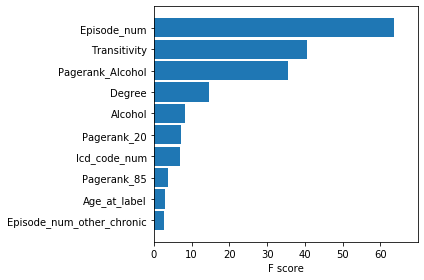

In [133]:
import matplotlib.pyplot as plt

ax = xgb.plot_importance(xgb_model, height = 0.9, max_num_features=10, title = None, grid=False, show_values=False, importance_type='gain', ylabel=None)
#xgb.plot_importance(xgb_model, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', fmap='', importance_type='weight', max_num_features=None, grid=True, show_values=True, **kwargs)
ax.figure.tight_layout()
ax.figure.savefig('../results/Figure2.png', dpi = 200)

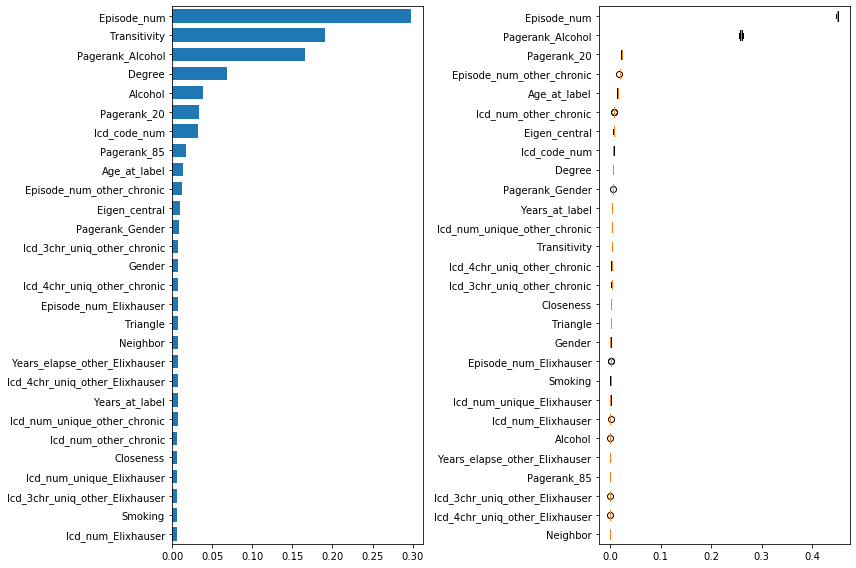

In [134]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

xgb_model.feature_importances_  ##[xgb_importance_sorted_idx]



result = permutation_importance(xgb_model, X_train, y_train, 
                                random_state=1142)
perm_sorted_idx = result.importances_mean.argsort()

xgb_importance_sorted_idx = np.argsort(xgb_model.feature_importances_)
xgb_ypos = np.arange(0, len(xgb_model.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# fig, (ax1) = plt.subplots(1, figsize=(12, 8))
ax1.barh(xgb_ypos,
         xgb_model.feature_importances_[xgb_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X.columns.values[xgb_importance_sorted_idx])
ax1.set_yticks(xgb_ypos)
ax1.set_ylim((0, len(xgb_model.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns.values[perm_sorted_idx])
fig.tight_layout()
#plt.savefig('Variable_importance_2_perm_with_net.png', dpi=1000)
plt.show()


When features are collinear, permutating one feature will have little effect on the models performance because it 
can get the same information from a correlated feature. One way to handle multicollinear features is by performing 
hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature 
from each cluster. First, we plot a heatmap of the correlated features:

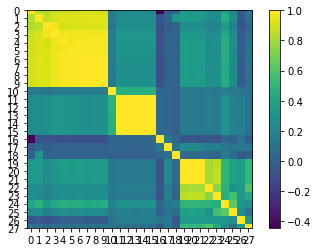

In [135]:

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
defaultdict(list)

import matplotlib.pyplot as plt
import numpy as np


#fig, (ax2) = plt.subplots(1, 1, figsize=(12, 6))

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.values.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

plt.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
plt.colorbar()
plt.xticks(dendro_idx)
plt.yticks(dendro_idx)
#plt.set_xticklabels(dendro['ivl'], rotation=90)
#plt.set_yticklabels(dendro['ivl'])
#fig.suptitle("Variable correlation", fontsize=14)#, va = "bottom")
#fig.tight_layout()
#plt.savefig('Variable_cluster_with_network.png')

plt.show()

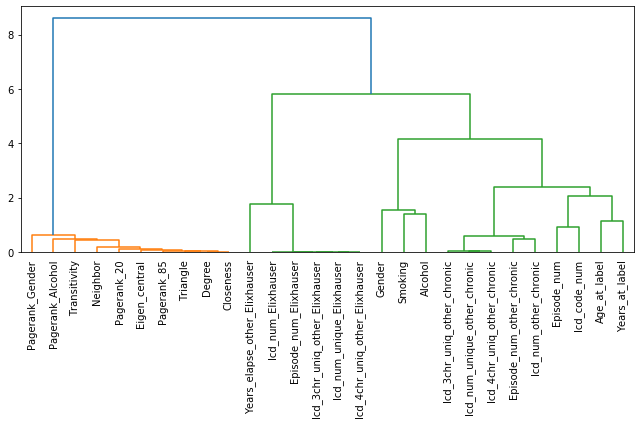

In [136]:

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
defaultdict(list)

import matplotlib.pyplot as plt
import numpy as np


fig, (ax1) = plt.subplots(1, 1, figsize=(9,6 ))

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.values.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
#ax2.colorbar()

ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation=90 )
ax2.set_yticklabels(dendro['ivl'])
#fig.suptitle("Variable correlation", fontsize=14)#, va = "bottom")
fig.tight_layout()
plt.savefig('../results/Figure3.png', dpi = 200)

plt.show()

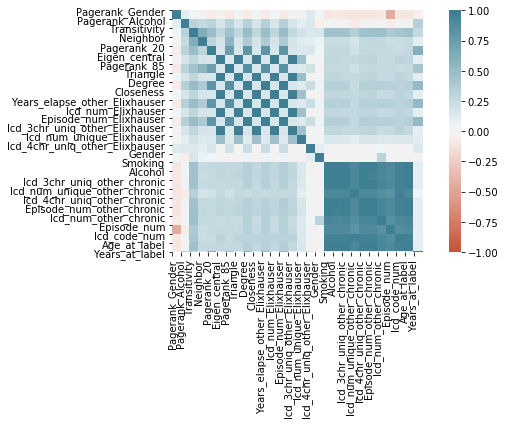

In [137]:
import seaborn as sns
corr = spearmanr(X).correlation


fig, (ax) = plt.subplots(1, 1, figsize=(9,6 ))


ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticks(dendro_idx)
ax.set_yticks(dendro_idx)
ax.set_xticklabels(dendro['ivl'], rotation=90)
ax.set_yticklabels(dendro['ivl'], rotation=360)
#fig.suptitle("Variable correlation", fontsize=14)#, va = "bottom")
fig.tight_layout()
plt.savefig('../results/Figure4.png', dpi = 200)



## 6. Best model 

Next, we manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and 
choose a feature from each cluster to keep, select those features from our dataset, and train a new Xgboost. 
The test accuracy of the new random forest did not change much compared to the Xgboost trained on the 
complete dataset.

In [138]:


cluster_ids = hierarchy.fcluster(corr_linkage, 0.2, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
X.columns.values[selected_features]


X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

X_test_sel.head()

xgb_model.fit(X_train_sel, y_train)
pred = xgb_model.predict(X_test_sel)
accuracy_score(y_test, pred)

print("Accuracy on test data: {:.4f}".format(xgb_model.score(X_test_sel, y_test)))




[13:45:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy on test data: 0.9517


In [139]:
best_result = xgb_model.score(X_test_sel, y_test)


In [140]:
df_best = pd.DataFrame({'best result': [best_result]})

In [141]:
df_best = df_best.round(4)

In [142]:
df_best.to_csv("../results/best_result.csv", index = False)

In [143]:
header = []
for col in X_train_sel.columns:
    header.append(col)

In [144]:
header = pd.DataFrame (header, columns = ['final feature'])

In [145]:
header.to_csv("../results/Table6.csv", index = False)



In [146]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred)
print(cf_matrix)

[[1085   48    3]
 [   5 3446  161]
 [   1   65 1042]]


In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories=index_to_label(np.unique(y_test)),
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Actual')
        plt.xlabel('Predicted' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    plt.savefig("../results/Figure5.png", dpi = 100)



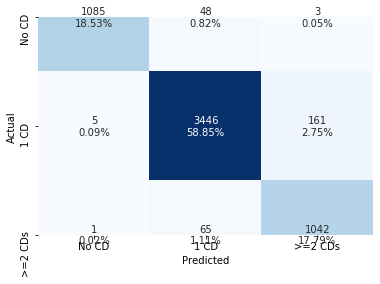

In [148]:
make_confusion_matrix(cf_matrix, cbar=False, sum_stats=False)

In [149]:
# Clear the current axes.
plt.cla() 
# Clear the current figure.
plt.clf() 
# Closes all the figure windows.
plt.close('all')

ax = xgb.plot_importance(xgb_model, height = 0.9, max_num_features=10, title = None, grid=False, show_values=False, importance_type='gain', ylabel=None)
ax.figure.tight_layout()
ax.figure.savefig('../results/Figure6.png', dpi = 200)

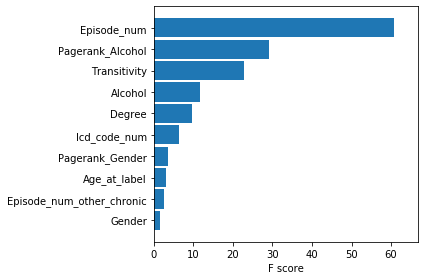

In [150]:

ax = xgb.plot_importance(xgb_model, height = 0.9, max_num_features=10, title = None, grid=False, show_values=False, importance_type='gain', ylabel=None)
ax.figure.tight_layout()
ax.figure.savefig('../results/Figure6.png', dpi = 100)

In [160]:
# Clear the current axes.
plt.cla() 
# Clear the current figure.
plt.clf() 
# Closes all the figure windows.
plt.close('all')

## 7. KDE

Finally, we consider the first four features as an example to demonstrate their distribution dissimilarities across three classes. Figure 7 presents the corresponding kernel distribution estimations based on the density distributions for these four attributes. According to Figure 7(a), the patients with one episode are the afflicted group for the number of episodes. As a result, the plot reveals that the number of episodes is an important factor in predicting comorbidity and multimorbidity. We observed similar distinguished distributions for the other three features in Figures 7(b)-(d).

In [151]:
df_kde_episode_num = pd.merge(
    X['Episode_num'],
    y_array,
    how="inner",
    on = 'person_id')

df_kde_trasitivity = pd.merge(
    X['Transitivity'],
    y_array,
    how="inner",
    on = 'person_id')

df_kde_pagerank = pd.merge(
    X['Pagerank_Alcohol'],
    y_array,
    how="inner",
    on = 'person_id')

df_kde_alcohol = pd.merge(
    X['Alcohol'],
    y_array,
    how="inner",
    on = 'person_id')

df_kde_episode_num = df_kde_episode_num.rename(columns={0: "No CD", 1: "1 CD", 2: ">=2 CD"})
df_kde_trasitivity = df_kde_trasitivity.rename(columns={0: "No CD", 1: "1 CD", 2: ">=2 CD"})
df_kde_pagerank = df_kde_pagerank.rename(columns={0: "No CD", 1: "1 CD", 2: ">=2 CD"})
df_kde_alcohol= df_kde_alcohol.rename(columns={0: "No CD", 1: "1 CD", 2: ">=2 CD"})

In [152]:
df_kde_episode_num_nocd = df_kde_episode_num[df_kde_episode_num['No CD'] > 0]
df_kde_episode_num_1cd = df_kde_episode_num[df_kde_episode_num['1 CD'] > 0]
df_kde_episode_num_2cd = df_kde_episode_num[df_kde_episode_num['>=2 CD'] > 0]
df_kde_episode_num_nocd = df_kde_episode_num_nocd[["Episode_num"]]
df_kde_episode_num_1cd = df_kde_episode_num_1cd[["Episode_num"]]
df_kde_episode_num_2cd = df_kde_episode_num_2cd[["Episode_num"]]
df_kde_episode_num_1CD = df_kde_episode_num_1cd.rename(columns={"Episode_num": "1 CD"})
df_kde_episode_num_noCD = df_kde_episode_num_nocd.rename(columns={"Episode_num": "no CD"})
df1cd = df_kde_episode_num_1CD['1 CD'].tolist()
dfnocd = df_kde_episode_num_noCD['no CD'].tolist()
df_kde_episode_num_2CD = df_kde_episode_num_2cd.rename(columns={"Episode_num": ">=2 CD"})
df1cd = df_kde_episode_num_2CD['>=2 CD'].tolist()

In [153]:
df_kde_trasitivity_nocd = df_kde_trasitivity[df_kde_trasitivity['No CD'] > 0]
df_kde_trasitivity_1cd = df_kde_trasitivity[df_kde_trasitivity['1 CD'] > 0]
df_kde_trasitivity_2cd = df_kde_trasitivity[df_kde_trasitivity['>=2 CD'] > 0]
df_kde_trasitivity_nocd = df_kde_trasitivity_nocd[["Transitivity"]]
df_kde_trasitivity_1cd = df_kde_trasitivity_1cd[["Transitivity"]]
df_kde_trasitivity_2cd = df_kde_trasitivity_2cd[["Transitivity"]]
df_kde_trasitivity_1CD = df_kde_trasitivity_1cd.rename(columns={"Transitivity": "1 CD"})
df_kde_trasitivity_noCD = df_kde_trasitivity_nocd.rename(columns={"Transitivity": "no CD"})
df1cd = df_kde_trasitivity_1CD['1 CD'].tolist()
dfnocd = df_kde_trasitivity_noCD['no CD'].tolist()
df_kde_trasitivity_2CD = df_kde_trasitivity_2cd.rename(columns={"Transitivity": ">=2 CD"})
df1cd = df_kde_trasitivity_2CD['>=2 CD'].tolist()

In [154]:
df_kde_pagerank_nocd = df_kde_pagerank[df_kde_pagerank['No CD'] > 0]
df_kde_pagerank_1cd = df_kde_pagerank[df_kde_pagerank['1 CD'] > 0]
df_kde_pagerank_2cd = df_kde_pagerank[df_kde_pagerank['>=2 CD'] > 0]
df_kde_pagerank_nocd = df_kde_pagerank_nocd[["Pagerank_Alcohol"]]
df_kde_pagerank_1cd = df_kde_pagerank_1cd[["Pagerank_Alcohol"]]
df_kde_pagerank_2cd = df_kde_pagerank_2cd[["Pagerank_Alcohol"]]
df_kde_pagerank_1CD = df_kde_pagerank_1cd.rename(columns={"Pagerank_Alcohol": "1 CD"})
df_kde_pagerank_noCD = df_kde_pagerank_nocd.rename(columns={"Pagerank_Alcohol": "no CD"})
df1cd = df_kde_pagerank_1CD['1 CD'].tolist()
dfnocd = df_kde_pagerank_noCD['no CD'].tolist()
df_kde_pagerank_2CD = df_kde_pagerank_2cd.rename(columns={"Pagerank_Alcohol": ">=2 CD"})
df1cd = df_kde_pagerank_2CD['>=2 CD'].tolist()

In [155]:
df_kde_alcohol_nocd = df_kde_alcohol[df_kde_alcohol['No CD'] > 0]
df_kde_alcohol_1cd = df_kde_alcohol[df_kde_alcohol['1 CD'] > 0]
df_kde_alcohol_2cd = df_kde_alcohol[df_kde_alcohol['>=2 CD'] > 0]
df_kde_alcohol_nocd = df_kde_alcohol[["Alcohol"]]
df_kde_alcohol_1cd = df_kde_alcohol[["Alcohol"]]
df_kde_alcohol_2cd = df_kde_alcohol_2cd[["Alcohol"]]
df_kde_alcohol_1CD = df_kde_alcohol_1cd.rename(columns={"Alcohol": "1 CD"})
df_kde_alcohol_noCD = df_kde_alcohol_nocd.rename(columns={"Alcohol": "no CD"})
df1cd = df_kde_alcohol_1CD['1 CD'].tolist()
dfnocd = df_kde_alcohol_noCD['no CD'].tolist()
df_kde_alcohol_2CD = df_kde_alcohol_2cd.rename(columns={"Alcohol": ">=2 CD"})
df1cd = df_kde_alcohol_2CD['>=2 CD'].tolist()

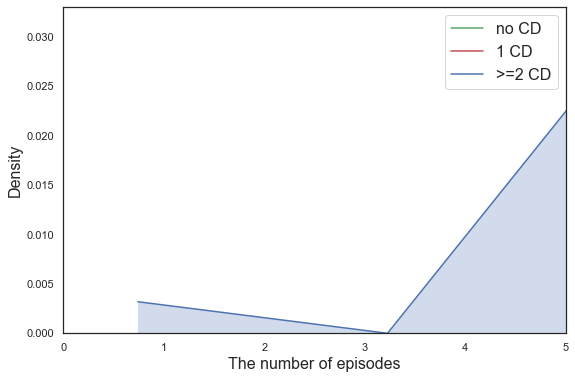

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Liberation Sans"
sns.set(font="Liberation Sans")
plt.rcParams["figure.figsize"]=9,6
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 

#sns.set(font_scale =5)
sns.set(style="white")
# plotting both distibutions on the same figure
fig = sns.kdeplot(df_kde_episode_num_noCD["no CD"], shade=True, color="g",  label='no CD')
fig = sns.kdeplot(df_kde_episode_num_1CD["1 CD"], shade=True, color="r", label='1 CD')
fig = sns.kdeplot(df_kde_episode_num_2CD[">=2 CD"], shade=True, color="b", label='>=2 CD')
plt.xlim(0, 5, )
plt.legend(fontsize = 16)
plt.xlabel('The number of episodes', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.savefig('../results/Figure7a.png', dpi = 200)

In [161]:
# Clear the current axes.
plt.cla() 
# Clear the current figure.
plt.clf() 
# Closes all the figure windows.
plt.close('all')

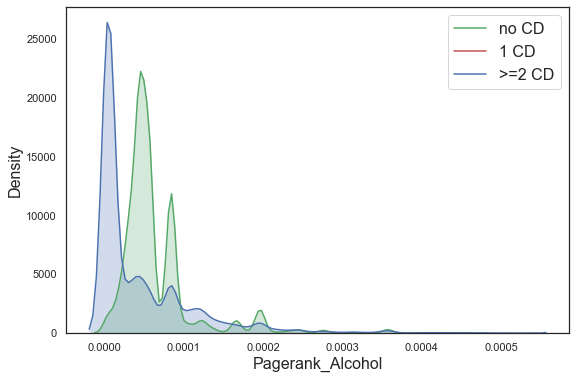

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=9,6
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="white")
# plotting both distibutions on the same figure
fig = sns.kdeplot(df_kde_pagerank_noCD["no CD"], shade=True, color="g",  label='no CD')
fig = sns.kdeplot(df_kde_pagerank_1CD["1 CD"], shade=True, color="r", label='1 CD')
fig = sns.kdeplot(df_kde_pagerank_2CD[">=2 CD"], shade=True, color="b", label='>=2 CD')
#plt.xlim(0, 0.1)
plt.legend(fontsize = 16)
plt.xlabel('Pagerank_Alcohol', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.savefig('../results/Figure7b.png', dpi = 200)

In [163]:
# Clear the current axes.
plt.cla() 
# Clear the current figure.
plt.clf() 
# Closes all the figure windows.
plt.close('all')

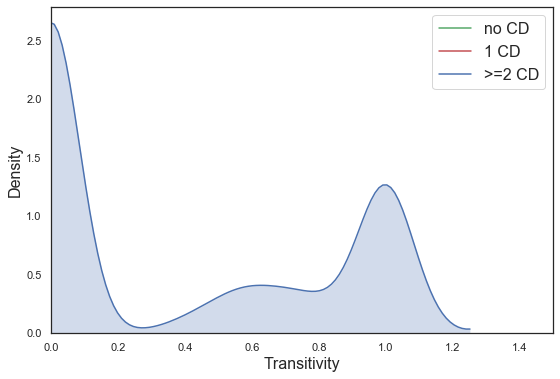

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=9,6
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="white")
# plotting both distibutions on the same figure
fig = sns.kdeplot(df_kde_trasitivity_noCD["no CD"], legend=True, shade=True, color="g",  label='no CD')
fig = sns.kdeplot(df_kde_trasitivity_1CD["1 CD"], shade=True, color="r", label='1 CD')
fig = sns.kdeplot(df_kde_trasitivity_2CD[">=2 CD"], shade=True, color="b", label='>=2 CD')
plt.xlim(0, 1.5)
plt.legend(fontsize = 16)
plt.xlabel('Transitivity', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.savefig('../results/Figure7c.png', dpi = 200)

In [165]:
# Clear the current axes.
plt.cla() 
# Clear the current figure.
plt.clf() 
# Closes all the figure windows.
plt.close('all')

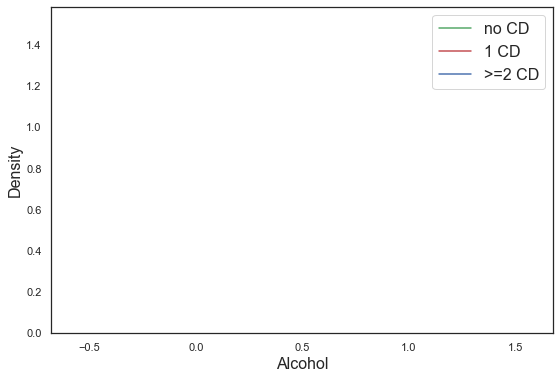

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=9,6
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="white")
# plotting both distibutions on the same figure
fig = sns.kdeplot(df_kde_alcohol_noCD["no CD"], shade=True, color="g",  label='no CD')
fig = sns.kdeplot(df_kde_alcohol_1CD["1 CD"], shade=True, color="r", label='1 CD')
fig = sns.kdeplot(df_kde_alcohol_2CD[">=2 CD"], shade=True, color="b", label='>=2 CD')
#plt.xlim(0, 0.1)
plt.legend(fontsize = 16)
plt.xlabel('Alcohol', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.savefig('../results/Figure7d.png', dpi = 200)